# Taller 3: Clasificación de Dígitos con CNN

Utilizando los datos presentados a continuación, diseñe una red neuronal que se capaz de separar los dígitos manuscritos. 

<div class="alert alert-block alert-info">
<b>Integrantes</b> <br>
&nbsp;&nbsp; • Daniel Andrade <br>
&nbsp;&nbsp; • Gabriel Cubides <br>
&nbsp;&nbsp; • Dewith Miramón <br>
&nbsp;&nbsp; • Santiago Prado <br>
</div>

Importamos las librerías

In [2]:
# Data
import numpy as np
import pandas as pd
import random

# Visualization 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lcmap
import seaborn as sns
plt.style.use('fivethirtyeight')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Deep Learning
import tensorflow as tf
from keras import models 
from keras import layers
from keras.layers import Dropout, Dense
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

## Cargamos los datos

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('Training set size:', train_images.shape)
print('Training labels size', train_labels.shape)
print('Test set size:', test_images.shape)
print('Test labels size:', test_labels.shape)

11501568/11490434 [==============================] - 0s 0us/step
Training set size: (60000, 28, 28)
Training labels size (60000,)
Test set size: (10000, 28, 28)
Test labels size: (10000,)


## Exploración

#### 1. Comprobar los datos de entrada

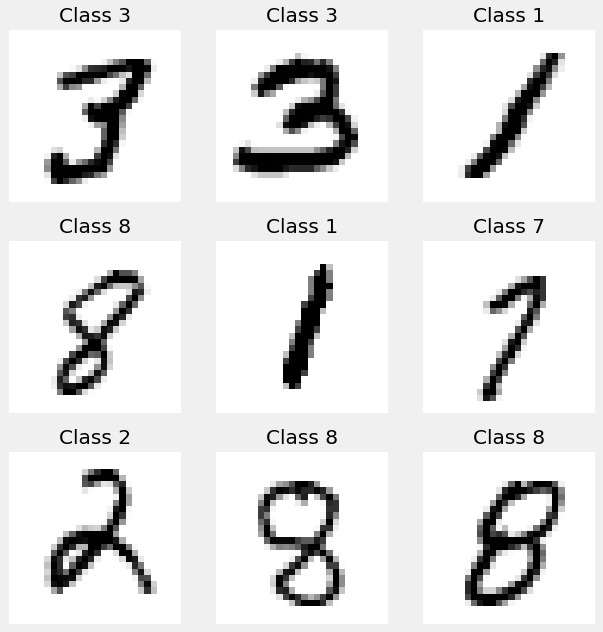

In [5]:
plt.rcParams['figure.figsize'] = (9,9) 

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(train_images))
    digit = train_images[num].reshape(28, 28)
    plt.imshow(digit, cmap=plt.cm.binary)
    plt.title("Class {}".format(train_labels[num]))
    plt.xticks([])
    plt.yticks([])
    plt.grid()
    
plt.tight_layout()
plt.show()

In [6]:
print('Train min-max:', np.min(train_images), '-',np.max(train_images))
print('Test min-max:', np.min(train_images), '-', np.max(train_images))

Train min-max: 0 - 255
Test min-max: 0 - 255


In [7]:
print('Train labels:', np.unique(train_labels))
print('Test labels:', np.unique(test_labels))

Train labels: [0 1 2 3 4 5 6 7 8 9]
Test labels: [0 1 2 3 4 5 6 7 8 9]


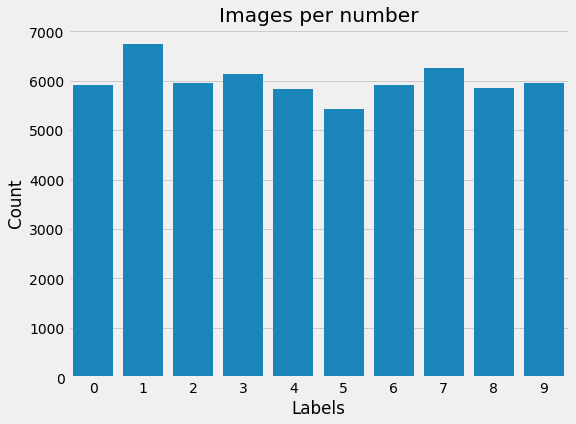

In [8]:
number_count = np.array(np.unique(train_labels, return_counts=True)).T


plt.figure(figsize=(8, 6))
sns.barplot(x=number_count[:, 0], y=number_count[:, 1], color=palette[0])

plt.title('Images per number')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

## Preprocesado

2. Convertir los datos a un formato compatible con la red

In [9]:
train_images = train_images.reshape((train_images.shape[0]),28,28,1)
#train_labels = train_labels.reshape(-1,1)

test_images = test_images.reshape((test_images.shape[0]),28,28,1)
#test_labels = test_labels.reshape(-1,1)

## Normalizacion

#### 3. Normalizar los datos de entrada (de 0 a 1) 

In [10]:
def normalize_input(images):
    print(images.shape, end=' --> ')
    images_scaled = np.interp(images, (images.min(), images.max()), (0, 1))
    print(images_scaled.shape)
    return images_scaled

In [11]:
train_images_scaled = normalize_input(train_images)
test_images_scaled = normalize_input(test_images)

(60000, 28, 28, 1) --> (60000, 28, 28, 1)
(10000, 28, 28, 1) --> (10000, 28, 28, 1)


## Modelado

#### 4. Dividir los datos en tres grupos: entrenamiento, validación y prueba

In [12]:
train_images_scaled, val_images_scaled, train_labels, val_labels = train_test_split(
    train_images_scaled, train_labels, test_size=0.3, random_state=42
)

In [13]:
print('Train shape:', train_images_scaled.shape)
print('Val shape:', val_images_scaled.shape)

Train shape: (42000, 28, 28, 1)
Val shape: (18000, 28, 28, 1)


In [14]:
print('Train labels shape:', train_labels.shape)
print('Val labels shape:', val_labels.shape)

Train labels shape: (42000,)
Val labels shape: (18000,)


## Modelado y Diseño

#### 5. Diseñar, entrenar y evaluar el desempeño de la red usando datos de prueba

In [15]:
def model_param(optimizer,
                layers_conv=[], 
                activation_conv=[],
                layers_network=[], 
                activation_network=[],
                type_conv=[]):
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
    
    for lay,acti, typ in zip(layers_conv, activation_conv, type_conv):
        if typ:
            model.add(layers.Conv2D(lay, (3, 3), activation=acti, padding='same'))
        else:
            model.add(layers.MaxPooling2D((2, 2)))    
    model.add(layers.Flatten())
    for lay,acti in zip(layers_network, activation_network):
        model.add(layers.Dense(lay, activation=acti))

    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer = optimizer,
                  loss = 'categorical_crossentropy',
                  metrics =['accuracy'])
    return model

def plot_history(history, metric='accuracy', epochs=range(1, 10)):
    """Plot the learning plots of the neural network using loss and another metric."""
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    metric_train = history.history[metric]
    metric_val = history.history['val_' + metric]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 6))
    sns.lineplot(x=epochs, y=loss_train, label='Train loss', ax=axes[0])
    sns.lineplot(x=epochs, y=loss_val, label='Val loss', ax=axes[0])
    axes[0].set_title('Model loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    sns.lineplot(x=epochs, y=metric_train, label=f'Train {metric}', ax=axes[1])
    sns.lineplot(x=epochs, y=metric_val, label=f'Val {metric}', ax=axes[1])
    axes[1].set_title(f'Model {metric}')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(metric.title())
    axes[1].legend()
    plt.show()


def fit_evaluate_nn(network, metric='accuracy', epochs=10, batch=50, verbose=0):
    """Fit a neural network and plot the learning curves"""
    history = network.fit(train_images_scaled, cat_train, epochs=epochs, batch_size=batch,
                          validation_data=[val_images_scaled,cat_val], verbose=verbose)
    plot_history(history, metric=metric, epochs=range(1, epochs + 1))
    print(f"Last train {metric}:", round(history.history[metric][-1], 3))
    print(f"Last validiation {metric}:", round(history.history['val_' + metric][-1], 3))


def evaluate_with_test(network, metric='accuracy', epochs=10, batch=50, verbose=0):
    print('Training...')
    history = network.fit(train_images_scaled, cat_train, epochs=epochs, batch_size=batch,
                          validation_data=[val_images_scaled,cat_val], verbose=verbose)
    print('-' * 30)
    test_loss, test_metric = network.evaluate(test_images_scaled, cat_test, verbose=0)
    print('Test loss:', round(test_loss, 3))
    print(f'Test {metric}:', round(test_metric, 3))

In [16]:
cat_train = to_categorical(train_labels)
cat_val = to_categorical(val_labels)
cat_test = to_categorical(test_labels)

In [17]:
cat_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Descripcion

*   **Optimizer:** adamax
*   **Activation:** relu
*   **Loss:** categorical_crossentropy
*   **Intermediate Layers:** 1
*   **Neurons per Layer:** 8
*   **Epochs:** 15
*   **Batch:** 40

In [18]:
%%time
hypers_baseline = {
    'optimizer': 'adamax',
    'layers_conv': [32, False], 
    'activation_conv': ['relu',False],
    'layers_network': [8], 
    'activation_network': ['relu'],
    'type_conv' :[1,0]
}
network_baseline = model_param(**hypers_baseline)
network_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 8)                 50184     
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                        

Epoch 1/15
1050/1050 [==============================] - 16s 5ms/step - loss: 0.8841 - accuracy: 0.7071 - val_loss: 0.4770 - val_accuracy: 0.8603
Epoch 2/15
1050/1050 [==============================] - 4s 4ms/step - loss: 0.3413 - accuracy: 0.9059 - val_loss: 0.2660 - val_accuracy: 0.9253
Epoch 3/15
1050/1050 [==============================] - 4s 4ms/step - loss: 0.2156 - accuracy: 0.9395 - val_loss: 0.1892 - val_accuracy: 0.9486
Epoch 4/15
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1516 - accuracy: 0.9577 - val_loss: 0.1384 - val_accuracy: 0.9609
Epoch 5/15
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1153 - accuracy: 0.9675 - val_loss: 0.1179 - val_accuracy: 0.9655
Epoch 6/15
1050/1050 [==============================] - 6s 5ms/step - loss: 0.0943 - accuracy: 0.9732 - val_loss: 0.1047 - val_accuracy: 0.9689
Epoch 7/15
1050/1050 [==============================] - 5s 4ms/step - loss: 0.0807 - accuracy: 0.9771 - val_loss: 0.1015 - val_accuracy

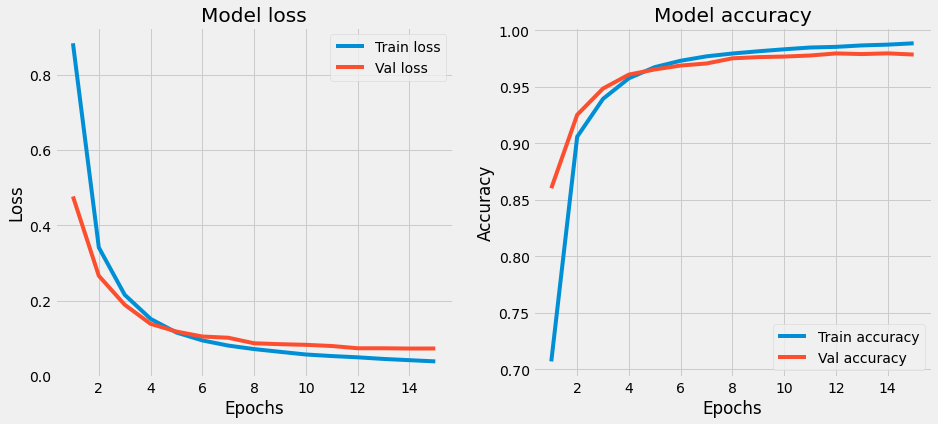

Last train accuracy: 0.989
Last validiation accuracy: 0.979


In [19]:
fit_evaluate_nn(network_baseline, epochs=15, batch=40, verbose=1)

In [20]:
train_images_scaled[0].shape

(28, 28, 1)

## 6. Probar con diferentes arquitecturas

### **Arquitectura 1**
#### Descripcion:

*   **Optimizer:** adam 
*   **Activation:** relu
*   **Loss:** categorical_crossentropy
*   **Intermediate Layers:** 2
*   **Neurons per Layer:** 4
*   **Epochs:** 10
*   **Batch:** 40

In [21]:
%%time
hypers_arq1 = {
    'optimizer': 'adam',
    'layers_conv': [32,False,32,False], 
    'activation_conv': ['relu',False,'relu',False],
    'layers_network': [10,8], 
    'activation_network': ['relu','relu'],
    'type_conv' :[1,0,1,0]
}
network_arq1 = model_param(**hypers_arq1)


CPU times: user 62.8 ms, sys: 0 ns, total: 62.8 ms
Wall time: 62.9 ms


#### Resumen

In [22]:
network_arq1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)             

#### Evaluacion de Modelo

Epoch 1/10
1050/1050 [==============================] - 6s 5ms/step - loss: 0.7028 - accuracy: 0.7669 - val_loss: 0.2061 - val_accuracy: 0.9466
Epoch 2/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1538 - accuracy: 0.9584 - val_loss: 0.1171 - val_accuracy: 0.9692
Epoch 3/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0989 - accuracy: 0.9728 - val_loss: 0.0900 - val_accuracy: 0.9759
Epoch 4/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0753 - accuracy: 0.9778 - val_loss: 0.0913 - val_accuracy: 0.9752
Epoch 5/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0610 - accuracy: 0.9818 - val_loss: 0.0751 - val_accuracy: 0.9803
Epoch 6/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0532 - accuracy: 0.9844 - val_loss: 0.0680 - val_accuracy: 0.9818
Epoch 7/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0464 - accuracy: 0.9862 - val_loss: 0.0711 - val_accuracy:

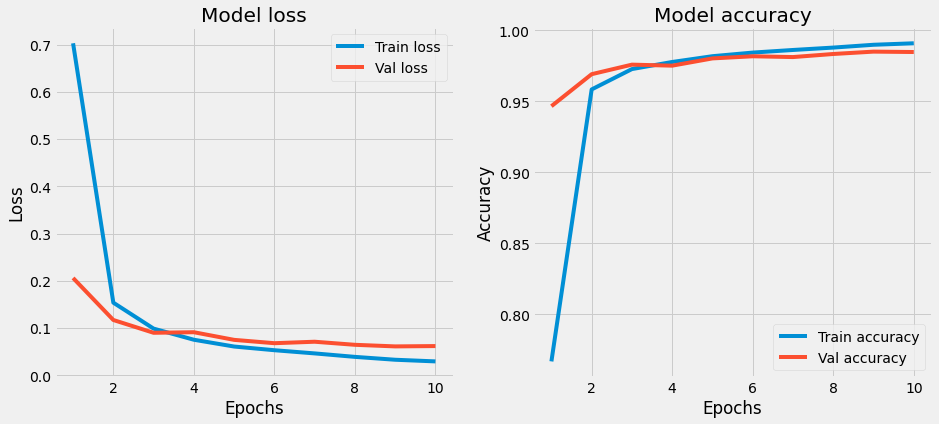

Last train accuracy: 0.991
Last validiation accuracy: 0.985


In [23]:
fit_evaluate_nn(network_arq1, epochs=10, batch=40, verbose=1)

### **Arquitectura 2**
#### Descripcion:

*   **Optimizer:** rmsprop
*   **Activation:** relu
*   **Loss:** categorical_crossentropy
*   **Intermediate Layers:** 2
*   **Neurons per Layer:** 8
*   **Epochs:** 12
*   **Batch:** 40

In [24]:
%%time
hypers_arq2 = {
    'optimizer': 'rmsprop',
    'layers_conv': [32, 64, False], 
    'activation_conv': ['relu','relu', False],
    'layers_network': [8], 
    'activation_network': ['relu'],
    'type_conv' :[1,1,0]
}
network_arq2 = model_param(**hypers_arq2)


CPU times: user 53.3 ms, sys: 0 ns, total: 53.3 ms
Wall time: 57 ms


#### Resumen

In [25]:
network_arq2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_5 (Dense)             (None, 8)                 100360    
                                                      

#### Evaluacion de Modelo

Epoch 1/15
1050/1050 [==============================] - 8s 6ms/step - loss: 1.9566 - accuracy: 0.2153 - val_loss: 1.8802 - val_accuracy: 0.2356
Epoch 2/15
1050/1050 [==============================] - 7s 6ms/step - loss: 1.4343 - accuracy: 0.4160 - val_loss: 1.1650 - val_accuracy: 0.5636
Epoch 3/15
1050/1050 [==============================] - 7s 6ms/step - loss: 1.0178 - accuracy: 0.6270 - val_loss: 0.8976 - val_accuracy: 0.6574
Epoch 4/15
1050/1050 [==============================] - 6s 6ms/step - loss: 0.8041 - accuracy: 0.6946 - val_loss: 0.7062 - val_accuracy: 0.7555
Epoch 5/15
1050/1050 [==============================] - 7s 6ms/step - loss: 0.5945 - accuracy: 0.8009 - val_loss: 0.5630 - val_accuracy: 0.7993
Epoch 6/15
1050/1050 [==============================] - 6s 6ms/step - loss: 0.4363 - accuracy: 0.8689 - val_loss: 0.3027 - val_accuracy: 0.9326
Epoch 7/15
1050/1050 [==============================] - 7s 6ms/step - loss: 0.2150 - accuracy: 0.9529 - val_loss: 0.1789 - val_accuracy:

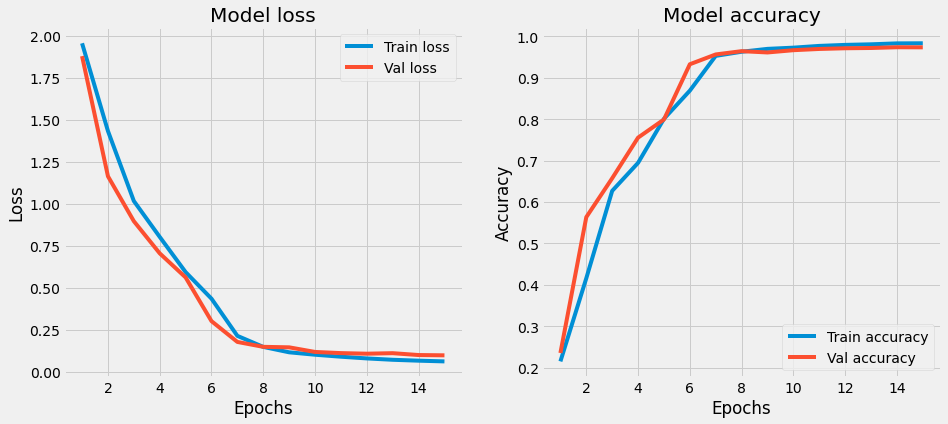

Last train accuracy: 0.983
Last validiation accuracy: 0.973


In [26]:
fit_evaluate_nn(network_arq2, epochs=15, batch=40, verbose=1)

### **Architecture 3**
#### Description:

*   **Optimizer:** adamax
*   **Activation:** relu
*   **Loss:** categorical_crossentropy
*   **Intermediate Layers:** 3
*   **Neurons per Layer:** 8, 6, 4
*   **Epochs:** 15
*   **Batch:** 40

In [27]:
%%time
hypers_arq3 = {
    'optimizer': 'adam',
    'layers_conv': [32,False,32,False], 
    'activation_conv': ['sigmoid',False,'relu',False],
    'layers_network': [12],
    'activation_network': ['sigmoid'],
    'type_conv' :[1,0,1,0]
}
network_arq3 = model_param(**hypers_arq3)

CPU times: user 59.9 ms, sys: 895 µs, total: 60.8 ms
Wall time: 66.2 ms


#### Resumen

In [28]:
network_arq3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1568)             

#### Evaluacion de Modelo

Epoch 1/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.8988 - accuracy: 0.7898 - val_loss: 0.3216 - val_accuracy: 0.9490
Epoch 2/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.2114 - accuracy: 0.9623 - val_loss: 0.1479 - val_accuracy: 0.9704
Epoch 3/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.1239 - accuracy: 0.9741 - val_loss: 0.0996 - val_accuracy: 0.9782
Epoch 4/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.0898 - accuracy: 0.9785 - val_loss: 0.0797 - val_accuracy: 0.9817
Epoch 5/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.0700 - accuracy: 0.9833 - val_loss: 0.0701 - val_accuracy: 0.9824
Epoch 6/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0565 - accuracy: 0.9856 - val_loss: 0.0681 - val_accuracy: 0.9815
Epoch 7/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0480 - accuracy: 0.9875 - val_loss: 0.0575 - val_accuracy:

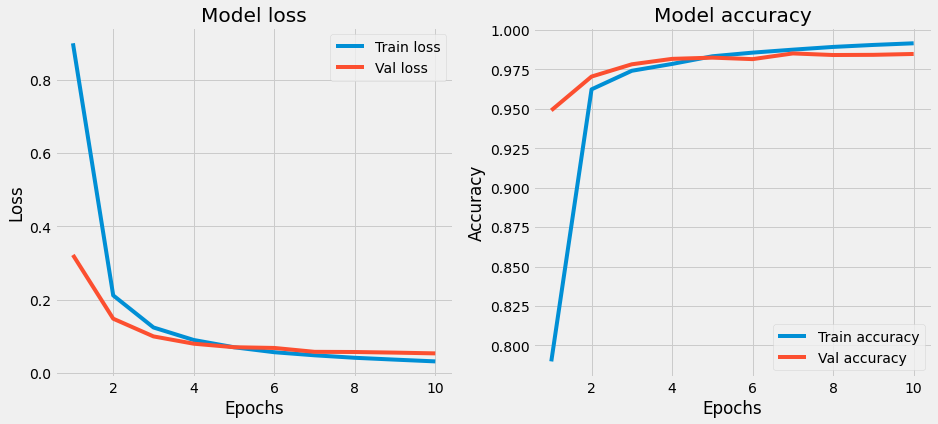

Last train accuracy: 0.992
Last validiation accuracy: 0.985


In [29]:
fit_evaluate_nn(network_arq3, epochs=10, batch=40, verbose=1)

### **Arquitectura 4**
#### Descripcion:

*   **Optimizer:** adam 
*   **Activation:** relu
*   **Loss:** categorical_crossentropy
*   **Intermediate Layers:** 2
*   **Neurons per Layer:** 4
*   **Epochs:** 10
*   **Batch:** 40

In [30]:
%%time
hypers_arq4 = {
    'optimizer': 'adam',
    'layers_conv': [32,False,32,False], 
    'activation_conv': ['relu',False,'relu',False],
    'layers_network': [20,20],
    'activation_network': ['relu','relu'],
    'type_conv' :[1,0,1,0]
}
network_arq4 = model_param(**hypers_arq4)

CPU times: user 57.9 ms, sys: 2.8 ms, total: 60.7 ms
Wall time: 62.1 ms


#### Resumen

In [31]:
network_arq4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1568)             

#### Evaluacion de Modelo

Epoch 1/12
1050/1050 [==============================] - 6s 5ms/step - loss: 0.2413 - accuracy: 0.9247 - val_loss: 0.1056 - val_accuracy: 0.9659
Epoch 2/12
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0724 - accuracy: 0.9780 - val_loss: 0.0761 - val_accuracy: 0.9779
Epoch 3/12
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0494 - accuracy: 0.9845 - val_loss: 0.0524 - val_accuracy: 0.9843
Epoch 4/12
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0381 - accuracy: 0.9884 - val_loss: 0.0485 - val_accuracy: 0.9856
Epoch 5/12
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 0.0458 - val_accuracy: 0.9862
Epoch 6/12
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0250 - accuracy: 0.9917 - val_loss: 0.0497 - val_accuracy: 0.9851
Epoch 7/12
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 0.0467 - val_accuracy:

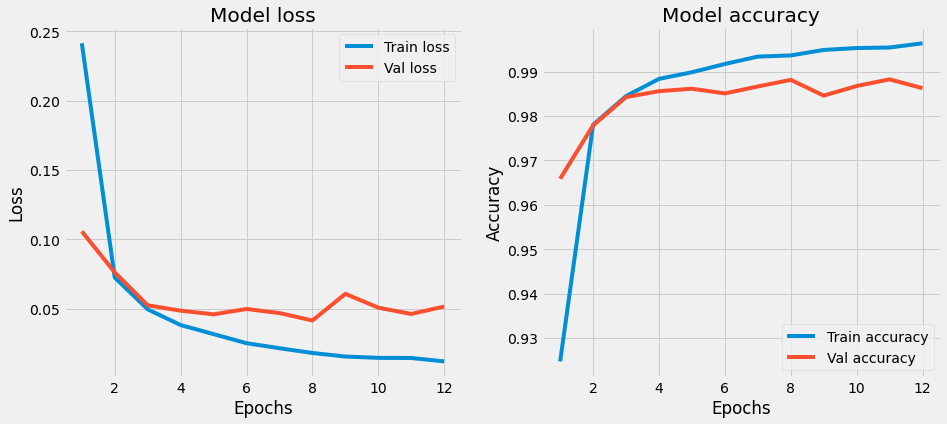

Last train accuracy: 0.996
Last validiation accuracy: 0.986


In [32]:
fit_evaluate_nn(network_arq4, epochs=12, batch=40, verbose=1)

### **Arquitectura 5**
#### Descripcion:

*   **Optimizer:** adam 
*   **Activation:** relu
*   **Loss:** categorical_crossentropy
*   **Intermediate Layers:** 2
*   **Neurons per Layer:** 4
*   **Epochs:** 10
*   **Batch:** 40

In [33]:
%%time
hypers_arq5 = {
    'optimizer': 'adam',
    'layers_conv': [32,False], 
    'activation_conv': ['relu',False],
    'layers_network': [20],
    'activation_network': ['relu'],
    'type_conv' :[1,0]
}
network_arq5 = model_param(**hypers_arq5)

CPU times: user 45.5 ms, sys: 1.01 ms, total: 46.5 ms
Wall time: 45.4 ms


#### Resumen



In [34]:
network_arq5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 6272)              0         
                                                                 
 dense_12 (Dense)            (None, 20)                125460    
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                      

#### Evaluacion de Modelo



Epoch 1/12
1050/1050 [==============================] - 5s 5ms/step - loss: 0.2097 - accuracy: 0.9382 - val_loss: 0.0811 - val_accuracy: 0.9767
Epoch 2/12
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0707 - accuracy: 0.9788 - val_loss: 0.0701 - val_accuracy: 0.9793
Epoch 3/12
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0483 - accuracy: 0.9855 - val_loss: 0.0606 - val_accuracy: 0.9823
Epoch 4/12
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0361 - accuracy: 0.9888 - val_loss: 0.0527 - val_accuracy: 0.9837
Epoch 5/12
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0260 - accuracy: 0.9914 - val_loss: 0.0682 - val_accuracy: 0.9815
Epoch 6/12
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.0570 - val_accuracy: 0.9844
Epoch 7/12
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.0633 - val_accuracy:

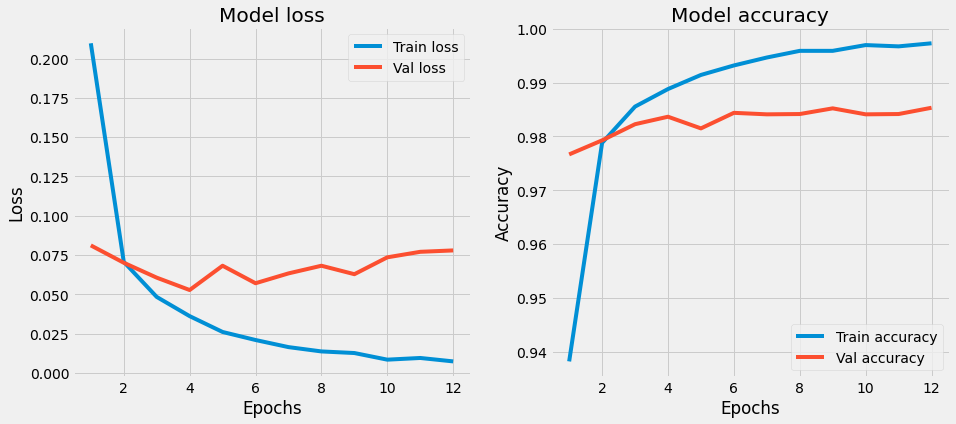

Last train accuracy: 0.997
Last validiation accuracy: 0.985


In [35]:
fit_evaluate_nn(network_arq5, epochs=12, batch=40, verbose=1)

### Evaluar Las Mejores Arquitecturas

Los modelos con el mejor fit son:


*   network_baseline
*   networkarq1
*   networkarq2
*   networkarq3
*   networkarq4



In [36]:
# network_baseline
test_loss_net_0, test_metric_net_0 = network_baseline.evaluate(test_images_scaled, cat_test,verbose=0)
print('Test Base')
print('Test loss:', round(test_loss_net_0, 3))
print('Test accuracy:', round(test_metric_net_0, 3))

Test Base
Test loss: 0.063
Test accuracy: 0.98


In [37]:
# networkarq1 
test_loss_net_1, test_metric_net_1 = network_arq1.evaluate(test_images_scaled, cat_test,verbose=0)
print('Test one')
print('Test loss:', round(test_loss_net_1, 3))
print('Test accuracy:', round(test_metric_net_1, 3))

Test one
Test loss: 0.053
Test accuracy: 0.985


In [38]:
# networkarq2
test_loss_net_2, test_metric_net_2 = network_arq2.evaluate(test_images_scaled, cat_test,verbose=0)
print('Test two')
print('Test loss:', round(test_loss_net_2, 3))
print('Test accuracy:', round(test_metric_net_2, 3))

Test two
Test loss: 0.093
Test accuracy: 0.975


In [39]:
# networkarq3
test_loss_net_3, test_metric_net_3 = network_arq3.evaluate(test_images_scaled, cat_test,verbose=0)
print('Test three')
print('Test loss:', round(test_loss_net_3, 3))
print('Test accuracy:', round(test_metric_net_3, 3))

Test three
Test loss: 0.052
Test accuracy: 0.984


In [40]:
# networkarq4
test_loss_net_4, test_metric_net_4 = network_arq4.evaluate(test_images_scaled, cat_test,verbose=0)
print('Test four')
print('Test loss:', round(test_loss_net_4, 3))
print('Test accuracy:', round(test_metric_net_4, 3))

Test four
Test loss: 0.044
Test accuracy: 0.988


#### Usar Data de Test con Mejor Modelo

*   Modelo Elegido: 4
*   Nombre: networkarq4



##### Matriz de Confusion

In [41]:
y_prob = network_arq4.predict(test_images) 
y_classes = y_prob.argmax(axis=-1)

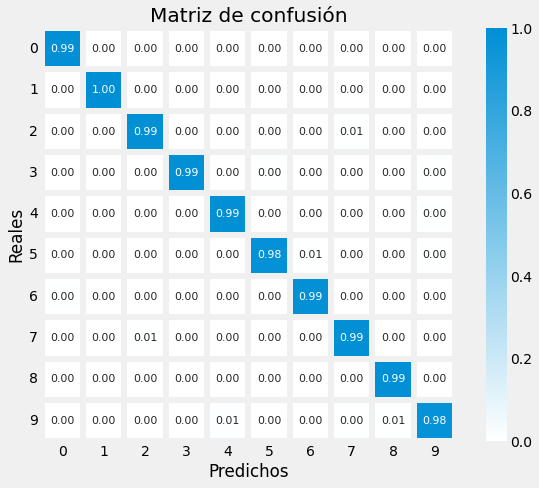

In [42]:
conf = pd.DataFrame(
    confusion_matrix(y_classes, test_labels.reshape(-1), normalize='true'), 
    columns=range(10), 
    index=range(10)
)

plt.figure(figsize=(9, 7))
sns.heatmap(
    conf,  cbar=True, square=True, annot=True, 
    fmt= '.2f', annot_kws={'size': 11}, 
    linewidths=5, linecolor='#f0f0f0',
    cmap=lcmap.from_list("", ['#ffffff', palette[0]]),
    vmin=0, vmax=1
)
plt.title('Matriz de confusión')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.xlabel('Predichos')
plt.ylabel('Reales')
plt.tight_layout()
plt.show()

## Conclusiones
#### 7. Discuta el resultado. ¿qué pueden concluir?

El modelo 4, fue uno de los que mas alta precision y menor perdida tuvo frente a los otros modelos:

*   Loss: 0.044
*   Test accuracy: 0.988

Al observar la grafica vemos la gran precision que tuvo en especial con el numero "1", que fue tuvo la mas alta de las precisiones frente a los demas numeros.

La arquitectura descrita para este modelo es la siguiente

*   Optimizador: Adam
*   Pooling Layer : MaxPooling2D x 2
*   Kernel: 3x3
*   Canales: 1
*   Tamaño: 28x28
*   Mapas de caracteristicas: 32 "Feature Maps"
*   Capas Internas: 2
*   Neuronas de Capas: 20

Claramente la implementacion de MaxPooling2D, va a brindar una mejor precision cuando se trabaja con imagenes, ademas de lo anterior tambien debemos resaltar que el adam es uno de los optimizadores mas usados por su rapidez y precision, algo que pudimos comprobar en este modelo.

 A pesar de que el modelo 4 fue el mejor, los otros modelos elegidos tuvieron un excelente curva de aprendizaje pues la diferencia reflejanda entre todos no fue mayor a 5 puntos

 Dependiendo el problema que estemos tratando debemos tomar la mejor decision al determinar nuestro Pooling Layer, debido a que dependiendo del tipo de problema la dimensionalidad puede ser modificada a (1D, 2D, 3D) dependiendo el caso

El Overfitting es uno de las cosas que mas nos puede afectar, tal como vio reflejado en la grafica del Modelo 5, que a pesar de tener valores altos en (accuaracy) y bajos en (loss), se debe tener claridad en la cantida de epocas (epochs) que usamos por modelo.




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b5f66870-babf-4238-8476-084f8c5ee74a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>